In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from vae_models import CVAE

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [7]:
use_cuda = True
batch_size = 32
latent_size = 20 # z dim

# Enable CUDA, set tensor type and device
if use_cuda:
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda:0")
    print('GPU')
else:
    dtype = torch.FloatTensor
    device = torch.device("cpu")
    

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

loader_train = DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

loader_val = DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

GPU


In [5]:
def loss_bce_kld(x, x_hat, mu, log_var):
    """
    see Appendix B from VAE paper:
    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114
    0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    """
    BCE = F.binary_cross_entropy(x_hat, x.view(-1, 784), size_average=True)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return KLD + BCE


def to_var(x):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x


def one_hot(labels, n_class=10):
    vec = np.zeros((labels.shape[0], n_class))
    for ind, label in enumerate(labels):
        vec[ind, label] = 1
    return vec


def hot2label(vec):
    return np.where(vec)[0][0]


def inter_labels(y, n_class=10):
    targets = torch.zeros(n_class - 1, n_class)
    k = 0
    for i in range(targets.shape[1]):
        label = hot2label(y)
        if label == i:
            continue
        else:            
            targets[k, i] = 1
            k += 1
                    
    return to_var(targets)


def load_model(fp, use_cuda):
    if use_cuda:
        return torch.load(fp)
    else:
        return torch.load(fp, map_location=lambda storage, loc: storage)

In [53]:
dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0")
model = CVAE().type(dtype)

model.load_state_dict(torch.load('models/CVAE_0.0070.pt')['state_dict'])

In [54]:
def reconstruct(model, loader_data, loss_fn):
    
    intra_loss = []
    inter_loss = []
    
    pnorm_intra_loss = []
    pnorm_inter_loss = []
     
    model.eval()
    
    n_val = len(loader_data.dataset)

    for batch_idx, (x, y) in enumerate(loader_data):
        
        intra_batch_loss = 0
        inter_batch_loss = 0
        
        pnorm_intra_batch_loss = 0
        pnorm_inter_batch_loss = 0
        
        n_batch = x.size()[0]
        x = x.to(device)
        
        y = torch.from_numpy(one_hot(y))
        y = y.type(dtype)
        y = y.to(device)    
        
        x_hat, mu, log_var = model(x, y)
        intra_batch_loss += loss_fn(x, x_hat, mu, log_var).item()

        pnorm_intra_batch_loss += torch.dist(x.view(-1, 784), x_hat, 2) / x_hat.numel()
        
        for i in range(y.size()[0]):
            y_inter = inter_labels(y[i])
            x_expand = x[i].repeat(9, 1, 1, 1)        
            
            x_hat, mu, log_var = model(x_expand, y_inter)
            inter_batch_loss += loss_fn(x_expand, x_hat, mu, log_var).item()
            
            pnorm_inter_batch_loss += torch.dist(x_expand.view(-1, 784), x_hat, 2) / x_hat.numel()

        intra_loss.append(intra_batch_loss / n_batch)
        inter_loss.append(inter_batch_loss / (n_batch * 9))
        
        pnorm_intra_loss.append(pnorm_intra_batch_loss.item())
        pnorm_inter_loss.append(pnorm_inter_batch_loss.item())
        
    return intra_loss, inter_loss, pnorm_intra_loss, pnorm_inter_loss

In [55]:
intra_loss, inter_loss,  pnorm_intra_loss, pnorm_inter_loss = \
    reconstruct(model, loader_val, loss_bce_kld)

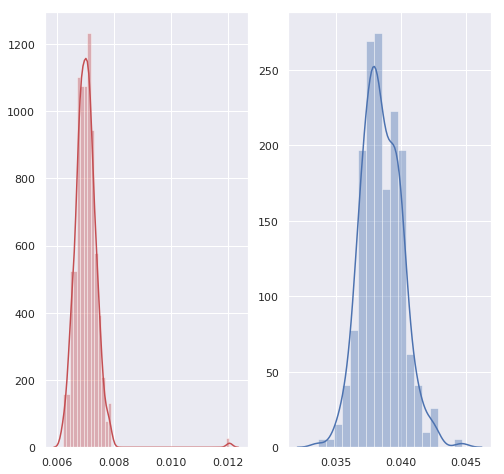

In [56]:
plt.rcParams['figure.figsize'] = 8, 8
sns.set()
fig, axis = plt.subplots(nrows=1, ncols=2)    
sns.distplot(intra_loss, ax = axis[0], color='r')
sns.distplot(inter_loss, ax = axis[1])

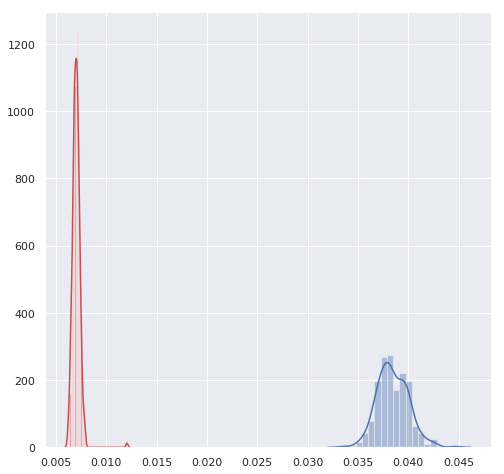

In [58]:
plt.rcParams['figure.figsize'] = 8, 8
sns.set()
sns.distplot(intra_loss, hist=True, kde=True, color='r')
sns.distplot(inter_loss, hist=True, kde=True, color='b')

In [ ]:
# todo: 
# 1) use euclidean distance as x_reconstruct
# todo: check normalisation via unit check, check batch influence

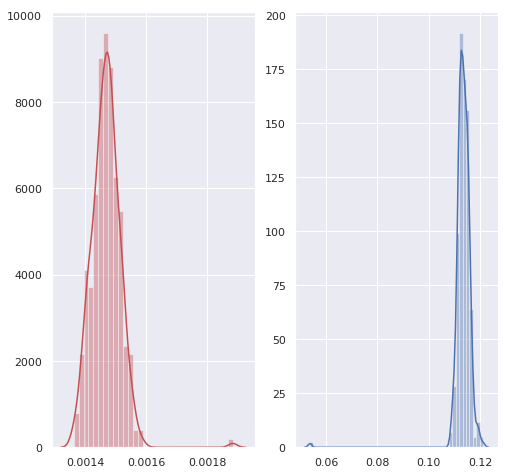

In [59]:
plt.rcParams['figure.figsize'] = 8, 8
sns.set()
fig, axis = plt.subplots(nrows=1, ncols=2)    
sns.distplot(pnorm_intra_loss, ax = axis[0], color='r')
sns.distplot(pnorm_inter_loss, ax = axis[1])

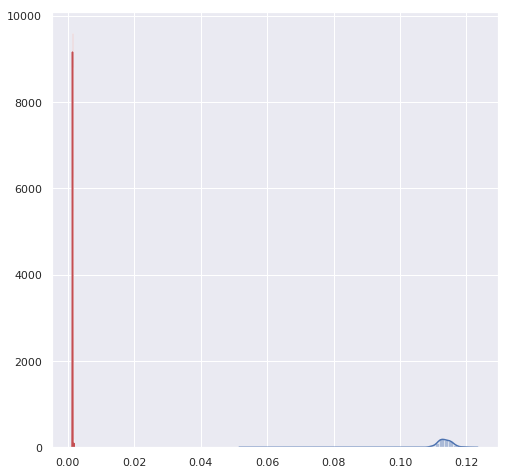

In [60]:
plt.rcParams['figure.figsize'] = 8, 8
sns.set()
sns.distplot(pnorm_intra_loss, hist=True, kde=True, color='r')
sns.distplot(pnorm_inter_loss, hist=True, kde=True, color='b')